In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


# v7 skan

In [3]:
ds = xr.Dataset()
for varname in ["s", "u", "v"]:
    ds[f"{varname}"] = open_da("ERA5", "plev", f"{varname}", "6H", 1999, [1, 3, 5, 7], -80, 30, 20, 75, levels=[200, 250, 300]).load()
    ds[f"{varname}_smo"] = smooth(ds[f"{varname}"], {"lon+lat": ("fft", 0.3)})
ds = compute_criterion(ds, flatten=True)
# ds["u"] = open_da("ERA5", "plev", "u", "6H", 1999, None, -80, 30, 20, 75).load()
# ds["v"] = open_da("ERA5", "plev", "v", "6H", 1999, None, -80, 30, 20, 75).load()

KeyboardInterrupt: 

In [3]:
from skan import draw
from skimage import filters, morphology
from gwdt import gwdt

In [4]:
img = ds["s"].isel(time=0).values
from scipy.ndimage import generate_binary_structure
from skimage.filters import threshold_otsu
import time as timer
t0 = timer.perf_counter()
norm_img = (img - img.min()) / (img.max() - img.min())
thresh = threshold_otsu(norm_img)
fgnd_img = norm_img - thresh
fgnd_img[fgnd_img < 0] = 0
structure = generate_binary_structure(img.ndim, 1)
Y = gwdt(fgnd_img, structure)
print(timer.perf_counter() - t0)

0.003872077912092209


In [12]:
from skimage.morphology import skeletonize
from scipy.ndimage import generate_binary_structure
from skimage.filters import threshold_otsu
def create_skeleton(X, y_thresh=0.1):
    X_norm = (X - X.min()) / (X.max() - X.min())
    X_fgnd = X_norm - y_thresh
    X_fgnd[X_fgnd < 0] = 0
    structure = generate_binary_structure(X.ndim, 1)
    Y = gwdt(X_fgnd, structure)
    return skeletonize(Y > y_thresh)
      

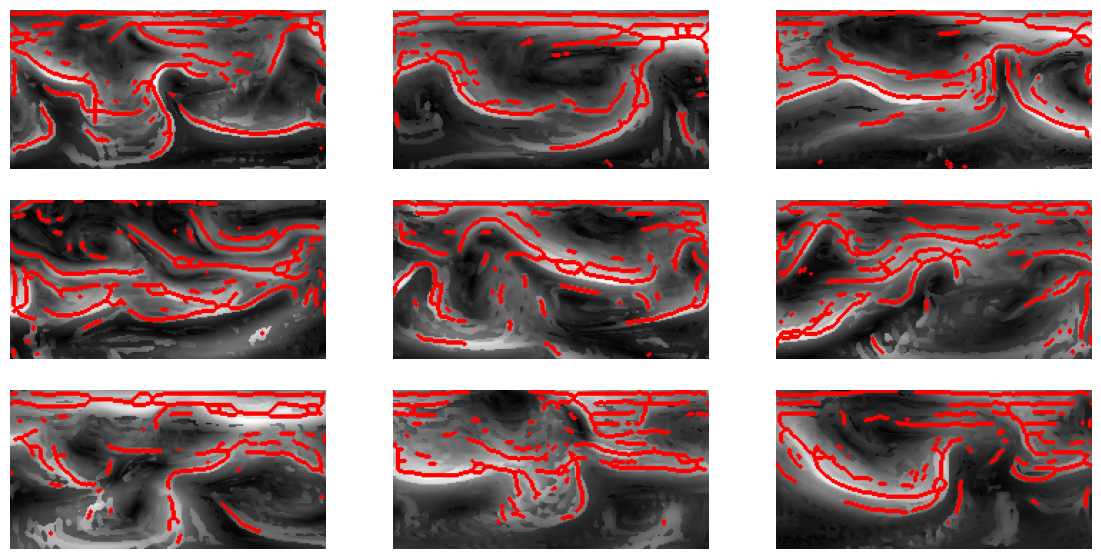

In [34]:
from skan import draw
fig, axes = plt.subplots(3, 3, figsize=(14, 7))
axes = axes.ravel()
its = np.random.randint(0, ds.time.shape[0], size=9)
for ax, it in zip(axes, its):
    X = ds["criterion"][it].values
    Y = ds["s"][it].values
    skeleton = skeletonize(X < np.quantile(X, 0.2))
    draw.overlay_skeleton_2d(Y / Y.max(), skeleton, dilate=1, axes=ax)


In [147]:
from skan.csr import skeleton_to_csgraph, csr_to_nbgraph, NBGraphBool, _build_paths
from scipy.sparse import csr_matrix

pixel_graph, coordinates = skeleton_to_csgraph(skeleton0)

In [151]:
np.diff(pixel_graph.indptr != 0)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [141]:
graph = csr_to_nbgraph(pixel_graph)
max_num_cycles = graph.indices.size // 4
buffer_size_offset = max_num_cycles
degrees = np.diff(graph.indptr)
visited_data = np.zeros(graph.data.shape, dtype=bool)
visited = NBGraphBool(
    graph.indptr,
    graph.indices,
    visited_data,
    graph.shape,
    np.broadcast_to(1.0, graph.shape[0]),
)
endpoints = degrees != 2
endpoint_degrees = degrees[endpoints]
num_paths = np.sum(endpoint_degrees)
path_indptr = np.zeros(num_paths + buffer_size_offset, dtype=int)
# the number of points that we need to save to store all skeleton
# paths is equal to the number of pixels plus the sum of endpoint
# degrees minus one (since the endpoints will have been counted once
# already in the number of pixels) *plus* the number of isolated
# cycles (since each cycle has one index repeated). We don't know
# the number of cycles ahead of time, but it is bounded by one quarter
# of the number of points.
n_points = (
    graph.indices.size
    + np.sum(np.maximum(0, endpoint_degrees - 1))
    + buffer_size_offset
)
path_indices = np.zeros(n_points, dtype=int)
path_data = np.zeros(path_indices.shape, dtype=float)
m, n = _build_paths(graph, path_indptr, path_indices, path_data, visited, degrees)
paths = csr_matrix((path_data[:n], path_indices[:n], path_indptr[:m]), shape=(m - 1, n))
# paths.data = X[coordinates].reshape(paths.shape).copy()

In [146]:
np.diff(graph.indptr)

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2,

In [142]:
paths.indptr

array([  0,   9,  38,  55, 140, 150, 155, 167, 187, 191, 202, 228, 261,
       296, 345, 354, 447, 469, 478, 482, 501, 510, 536, 575, 577, 589,
       616, 630, 638, 650, 683, 686], dtype=int32)

In [139]:
sums = np.add.reduceat(paths.data, paths.indptr[:-1])
lengths = np.diff(paths.indptr)
print()

IndexError: index 683 out-of-bounds in add.reduceat [0, 664)

# jet finding v5 ?

In [ ]:
ds = xr.Dataset()
ds["P"] = open_da("ERA5", "thetalev", "P", "6H", 1959, "JJA", -80, 20, 25, 75).load()
ds["u"] = open_da("ERA5", "thetalev", "u", "6H", 1959, "JJA", -80, 20, 25, 75).load()
ds["v"] = open_da("ERA5", "thetalev", "v", "6H", 1959, "JJA", -80, 20, 25, 75).load()
ds["s"] = open_da("ERA5", "thetalev", "s", "6H", 1959, "JJA", -80, 20, 25, 75).load()
ds["PV"] = open_da("ERA5", "thetalev", "PV", "6H", 1959, "JJA", -80, 20, 25, 75).load()

ds = compute_criterion(ds)

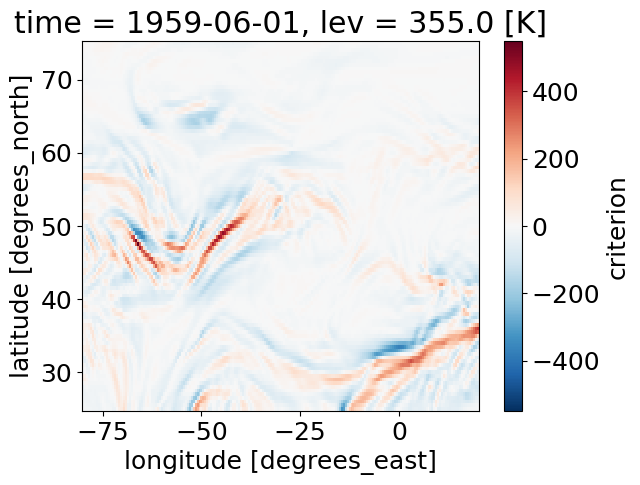

In [ ]:
(-ds["criterion"][0, 0]).plot()

In [ ]:
def mona_criterion(PV: xr.DataArray, cutoff: float = 0.4):
    criterion = smooth(PV, {"lon+lat": ("fft", 0.4)})
    criterion = np.log(criterion)
    criterion = criterion.differentiate("lon") ** 2 + criterion.differentiate("lat") ** 2
    return np.sqrt(criterion)

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


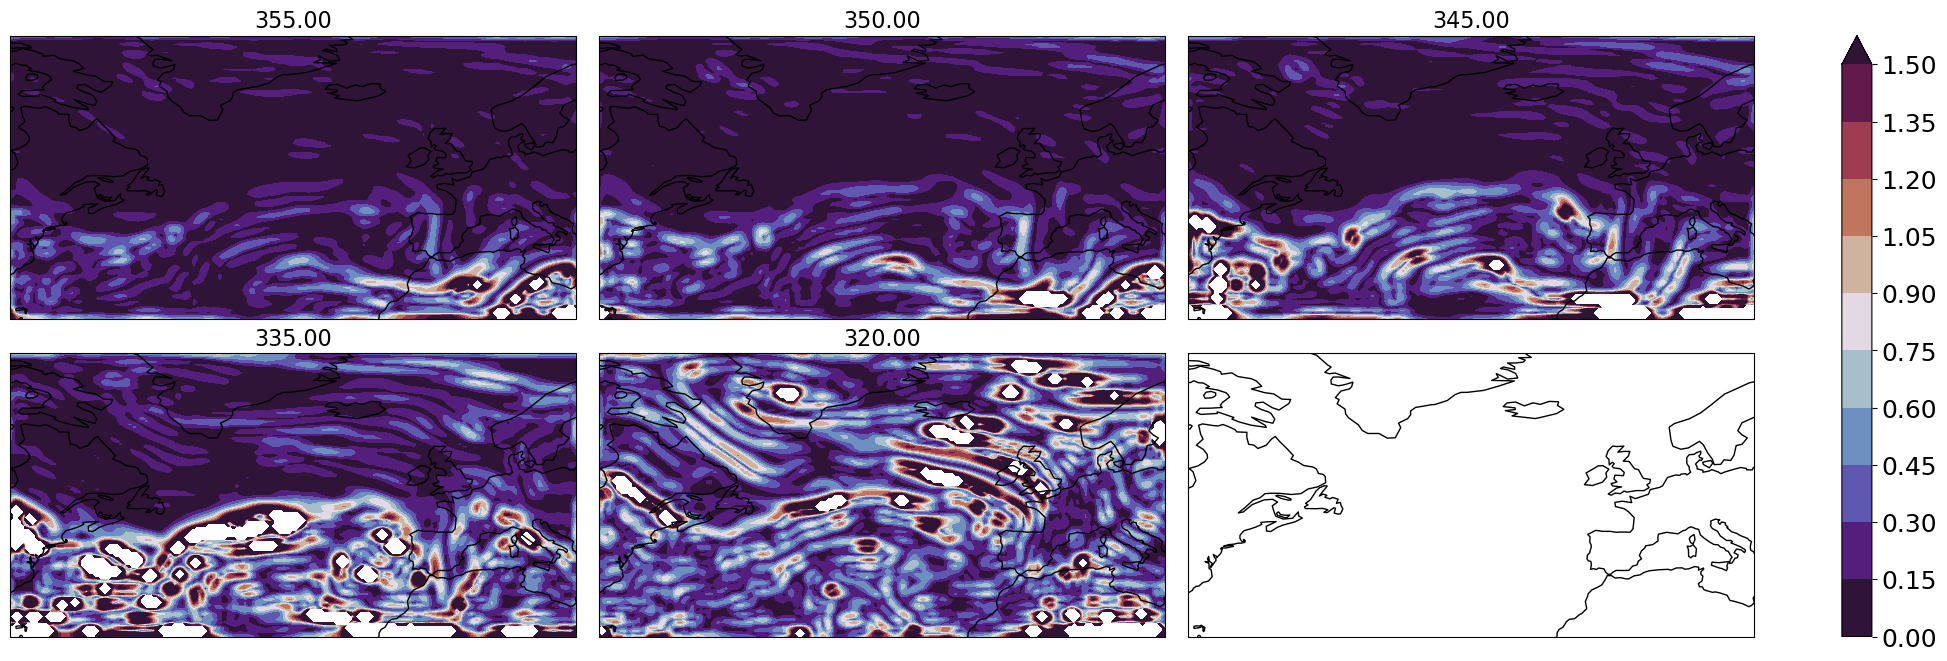

In [ ]:
clu = Clusterplot(2, 3, get_region(ds["P"]))
_ = clu.add_contourf([mona_criterion(ds["PV"][100, itheta], cutoff=0.8) for itheta in range(5)], nlevels=11, q=0.95, titles=ds.lev.values)

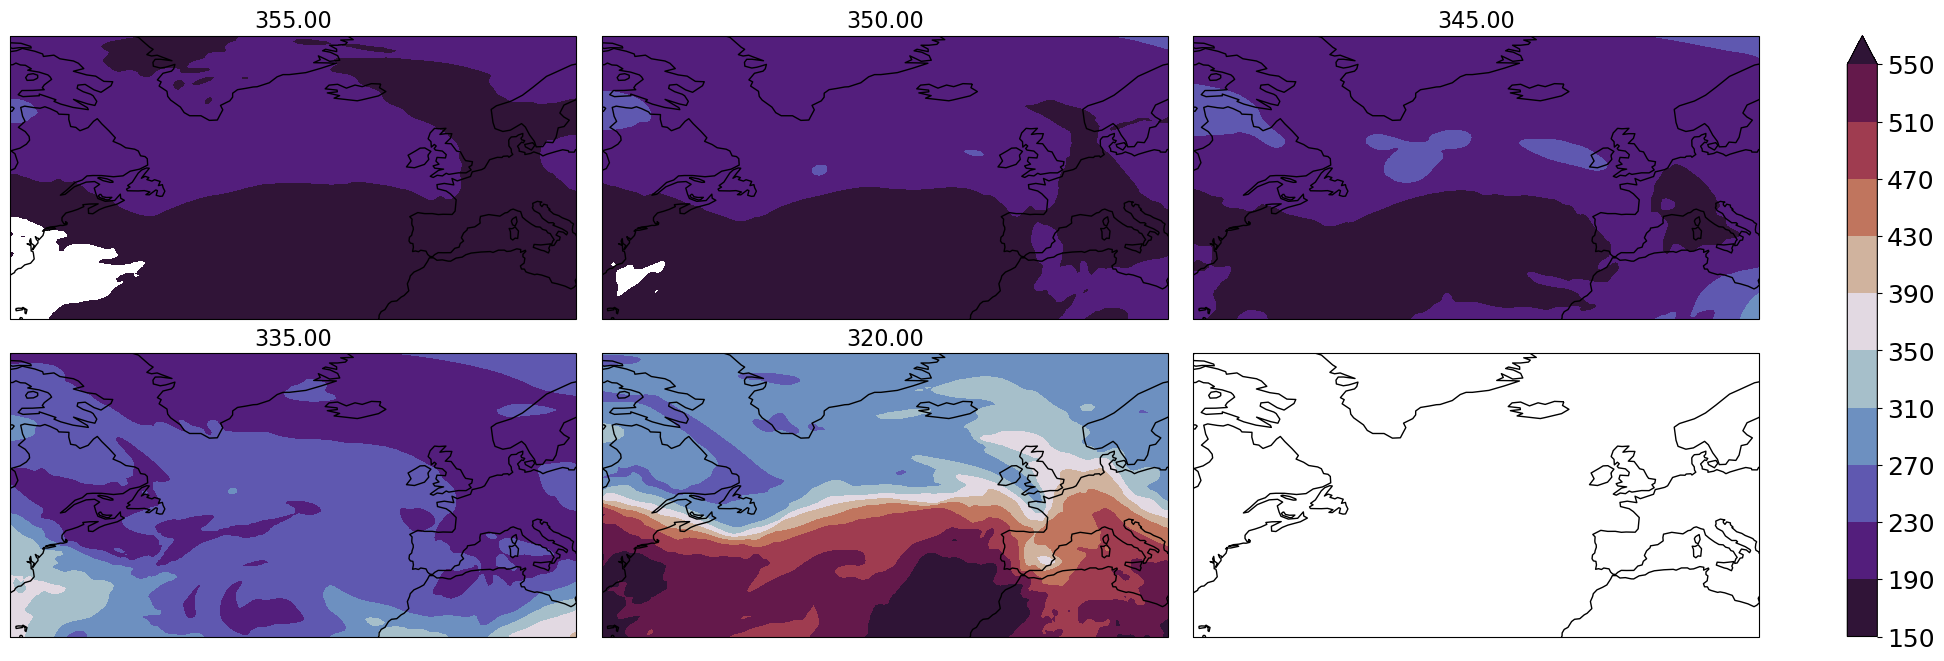

In [ ]:
clu = Clusterplot(2, 3, get_region(ds["P"]))
_ = clu.add_contourf([ds["P"][100, itheta] for itheta in range(5)], nlevels=11, q=0.95, titles=ds.lev.values)

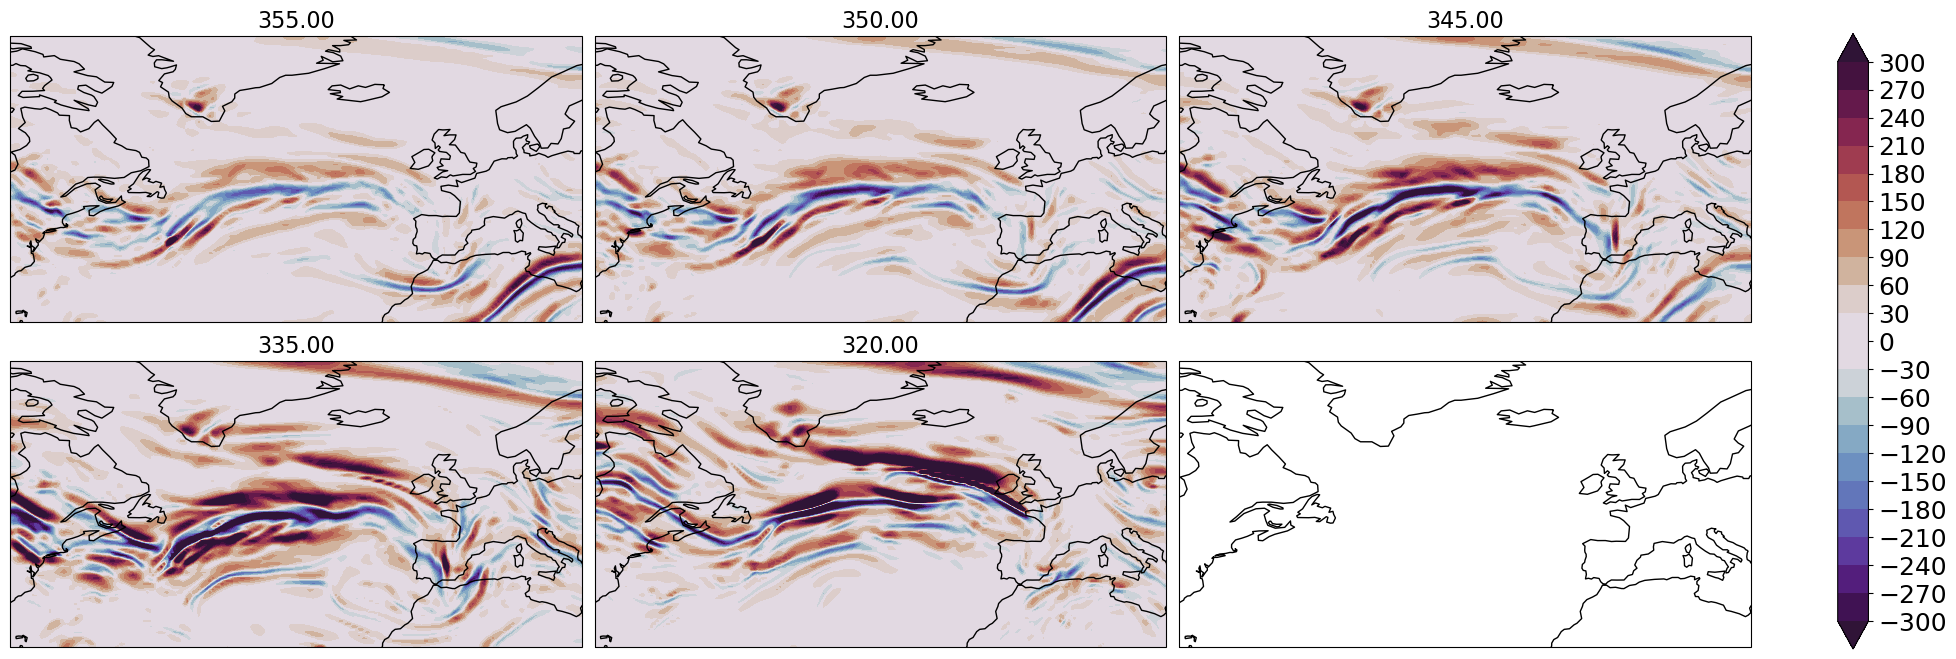

In [ ]:
clu = Clusterplot(2, 3, get_region(ds["P"]))
_ = clu.add_contourf([ds["criterion"][100, itheta] for itheta in range(5)], nlevels=11, q=0.99, titles=ds.lev.values)

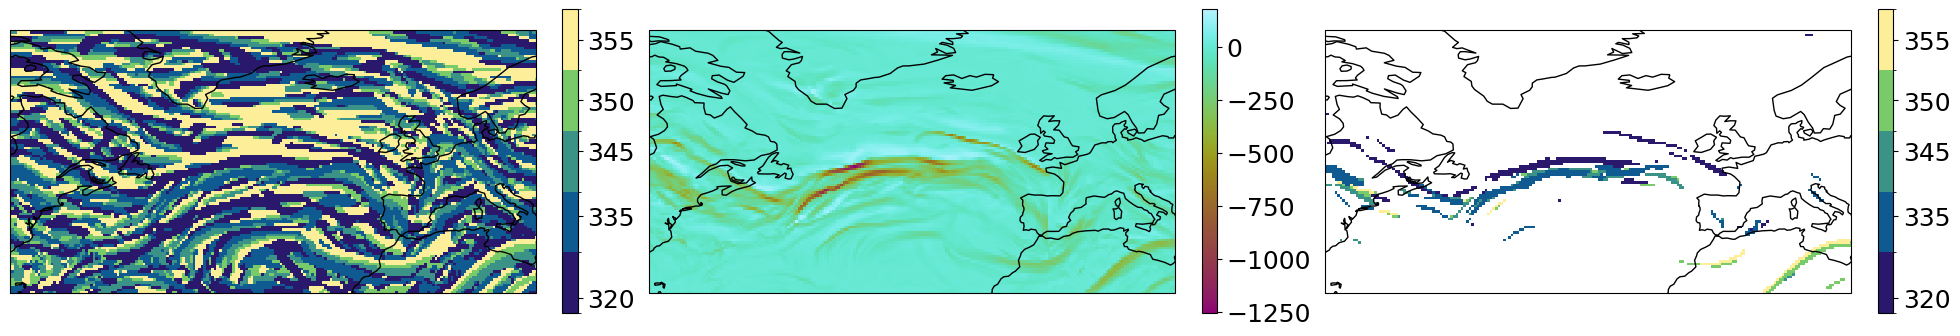

In [ ]:
clu = Clusterplot(1, 3, get_region(ds))
lon, lat = ds.lon.values, ds.lat.values
to_plot = ds.lev[ds["criterion"][100, :].argmin(dim='lev')].values
cmap = colormaps.haline
ticks = np.unique(to_plot)
ticks2 = np.concatenate([[315], ticks, [360]]) 
norm = BoundaryNorm((ticks2[:-1] + ticks2[1:]) / 2, cmap.N)
im = clu.axes[0].pcolormesh(lon, lat, to_plot, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
clu.fig.colorbar(im, ax=clu.axes[0], ticks=ticks, spacing='uniform')
to_plot = ds["criterion"][100, :].min(dim='lev')
im = clu.axes[1].pcolormesh(lon, lat, to_plot.values, transform=ccrs.PlateCarree(), cmap=colormaps.hawaii)
clu.fig.colorbar(im, ax=clu.axes[1])
to_plot = ds.lev[ds["criterion"][100, :].argmin(dim='lev')].where(to_plot < -200).values
im = clu.axes[2].pcolormesh(lon, lat, to_plot, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
clu.fig.colorbar(im, ax=clu.axes[2], ticks=ticks, spacing='uniform')

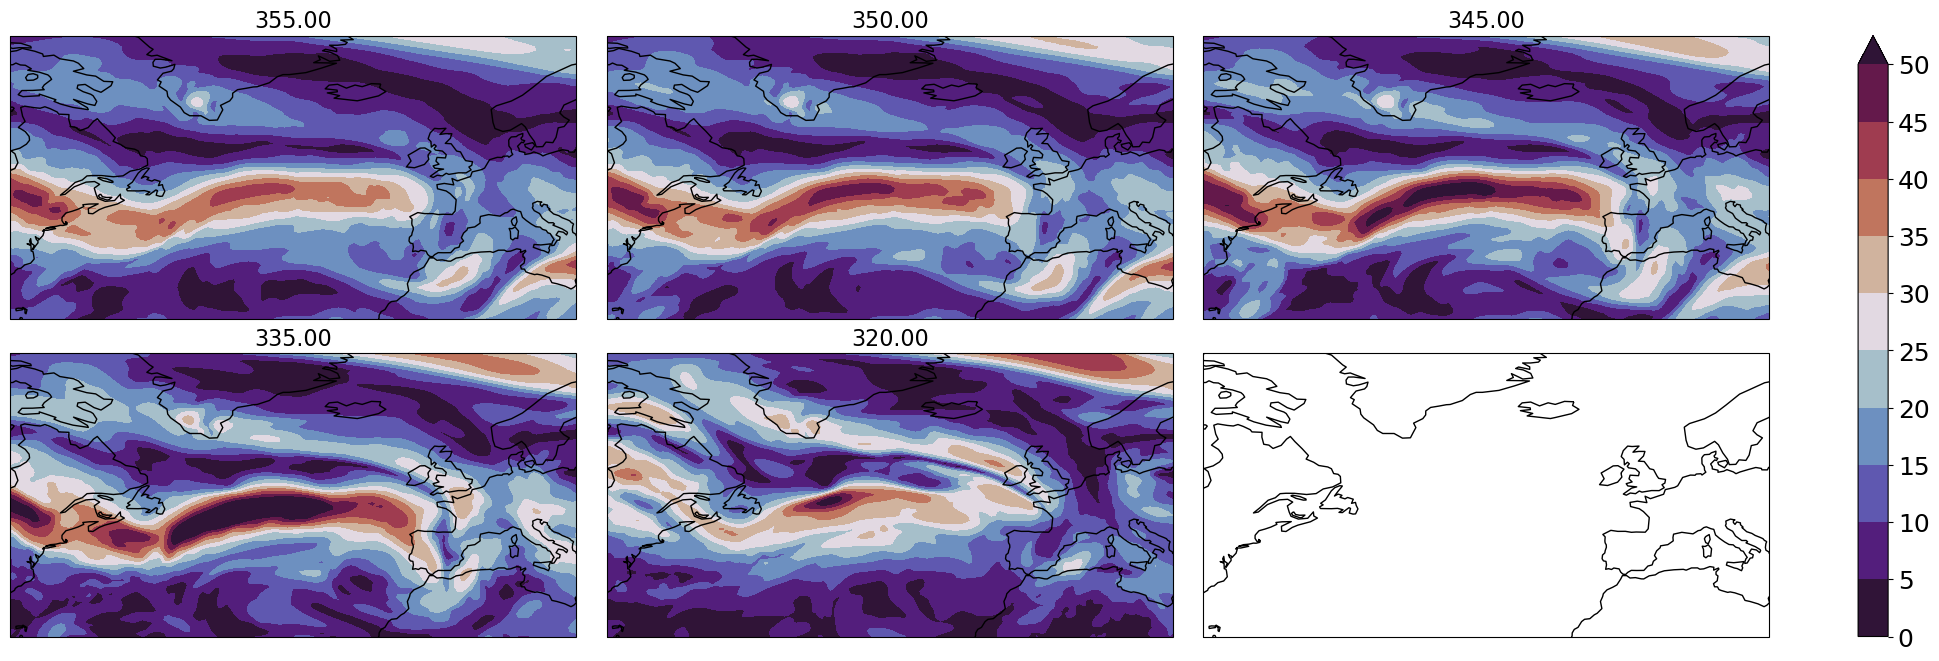

In [ ]:
clu = Clusterplot(2, 3, get_region(ds["P"]))
_ = clu.add_contourf([ds["s"][100, itheta] for itheta in range(5)], nlevels=11, q=0.99, titles=ds.lev.values)

# plev, v6

In [2]:
ds = xr.Dataset()
ds["s"] = open_da("ERA5", "plev", "s", "6H", 1999, None, -80, 30, 20, 80, [200, 250, 300]).load()
ds["u"] = open_da("ERA5", "plev", "u", "6H", 1999, None, -80, 30, 20, 80, [200, 250, 300]).load()
ds["v"] = open_da("ERA5", "plev", "v", "6H", 1999, None, -80, 30, 20, 80, [200, 250, 300]).load()
qss = xr.open_dataarray(f"{DATADIR}/ERA5/plev/s/6H/results/qs_clim.nc")

Elapsed time: 0.0238 seconds


100%|██████████| 8/8 [00:15<00:00,  1.89s/it]


Text(0.5, 0.98, '28-07-1999T06:00')

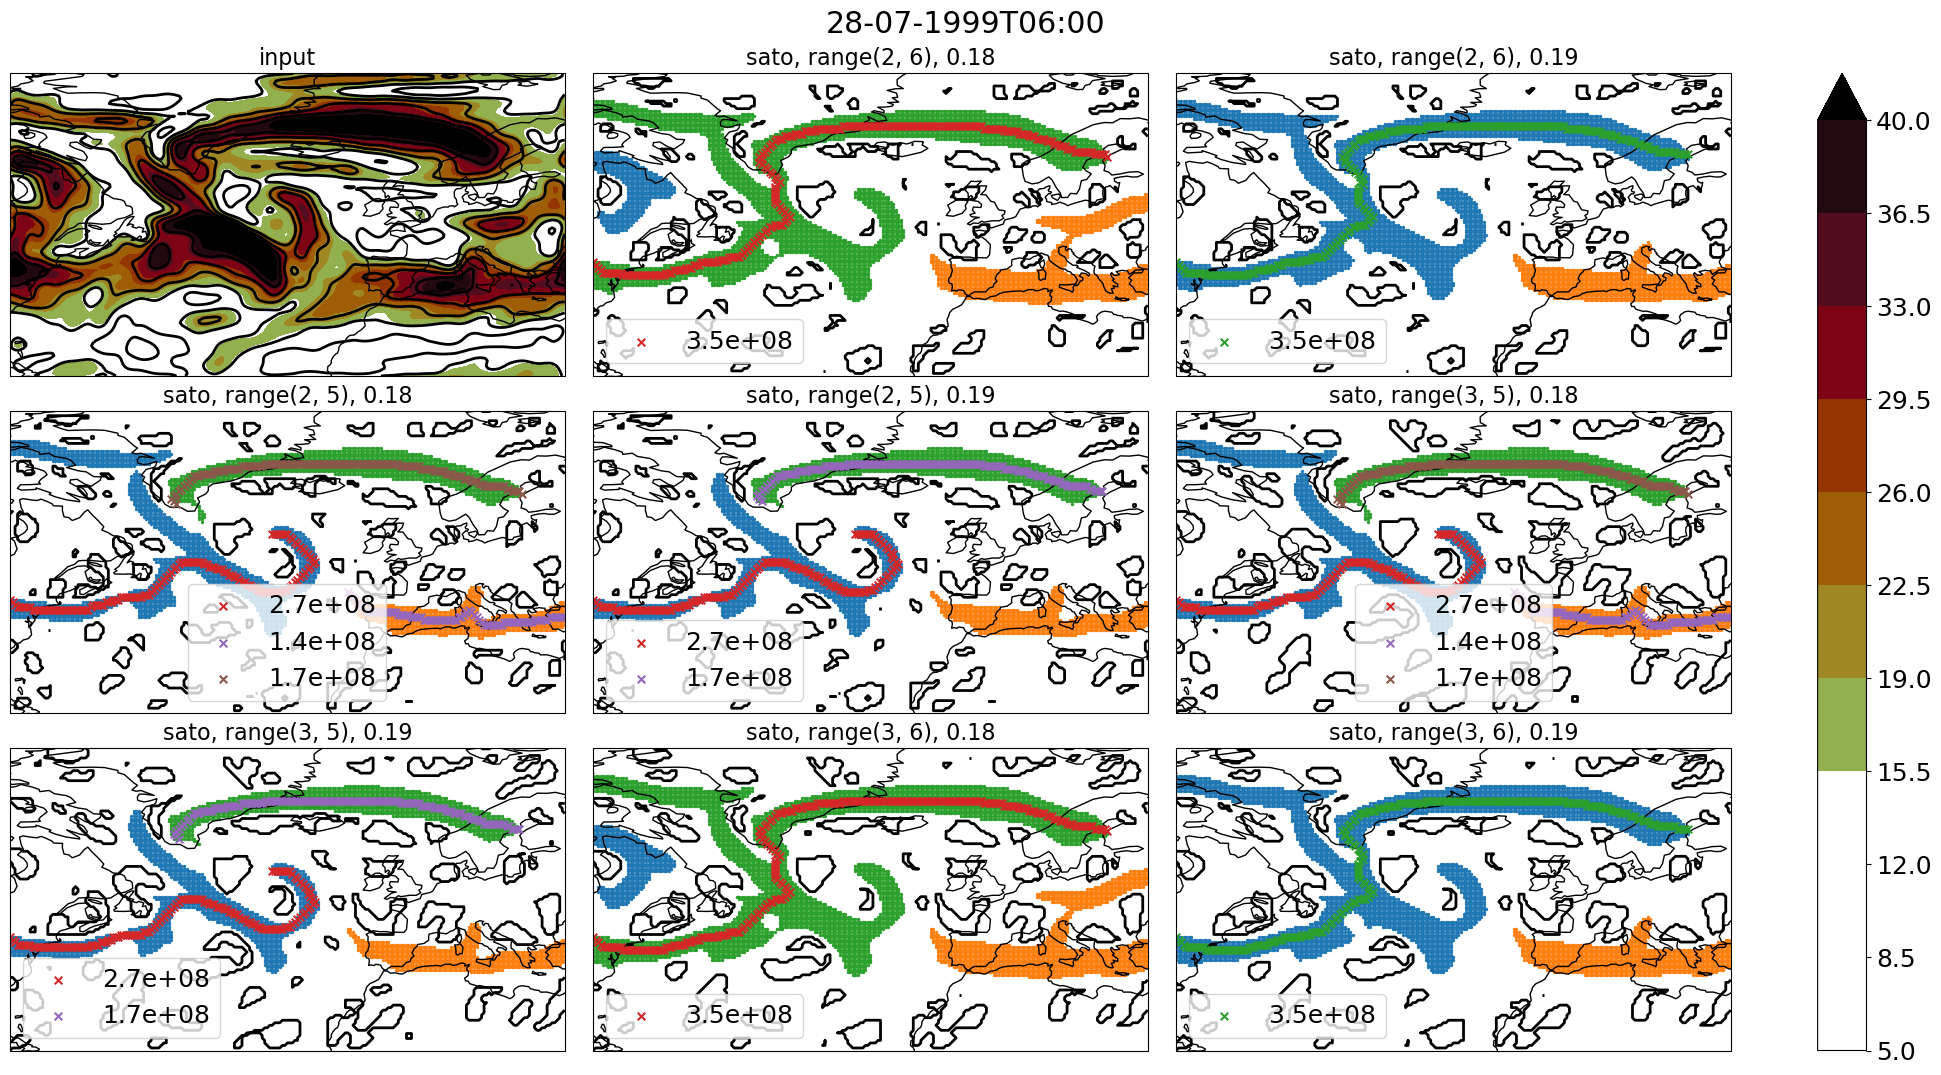

In [41]:
from skimage.filters import meijering, sato, frangi, hessian
clu = Clusterplot(3, 3, get_region(ds))
# it = np.random.randint(0, ds.time.shape[0])
# q = qss.loc[0.6, ds.time[it].dt.dayofyear.item()].item()
ds_ = ds.isel(time=it)
ds_ = flatten_by(ds_, "s")
with Timer():
    ds_["s_smo"] = smooth(ds_["s"], smooth_map={"lon+lat": ("fft", 0.25)})
titles = ["input"]
to_plot = [ds_["s_smo"]]
for ax, (filter_, sigmas, threshold) in tqdm(zip(clu.axes.ravel()[1:], product([sato], [range(2, 6), range(2, 5), range(3, 5), range(3, 6)], [0.18, 0.19])), total=8):
    fname = filter_.__name__
    black_ridges = fname == "hessian"
    multiply = fname == "sato"
    thisds = ds_.copy()
    thisds["s_smo"] = (("lat", "lon"), filter_(thisds["s_smo"] / thisds["s_smo"].max(), black_ridges=black_ridges, sigmas=sigmas) * (4 if multiply else 1))
    # thisds["s_smo"] = thisds["s"] / thisds["s"].max() * filter_(thisds["s"] / thisds["s"].max(), black_ridges=black_ridges, sigmas=sigmas, mode="constant", cval=0)
    to_plot.append(thisds["s_smo"])
    titles.append(f"{fname}, {sigmas}, {threshold:.2f}")
    groups, dist_mats = cluster_wind_speed(thisds, criterion_threshold=threshold, distance_function=pairwise_distances, min_size=500, distance_threshold=1.5)
    for group, dist_mat in zip(groups, dist_mats):
        ax.scatter(*group[["lon", "lat"]].to_numpy().T, s=2)
    jets = []
    for group, dist_mat in zip(groups, dist_mats):
        masked_weights = compute_weights(group, dist_mat)
        graph = csgraph_from_masked(masked_weights)
        jet = find_jets_in_group_v2(graph, group, dist_mat, 1.4e8)
        if jet is not None:
            jets.append(jet)
    for jet in jets:
        ax.scatter(*jet[["lon", "lat"]].to_numpy().T, marker="x", s=30, label=f"{jet_integral_haversine(jet[['lon', 'lat', 's']].to_numpy()):.1e}", zorder=2)
    ax.legend()
clu.add_contourf([to_plot[0]], transparify=3, nlevels=11, q=0.95, zorder=0)
_ = clu.add_contour(to_plot, titles=titles, zorder=1)
clu.fig.suptitle(ds.time[it].dt.strftime("%d-%m-%YT%H:00").item())

100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


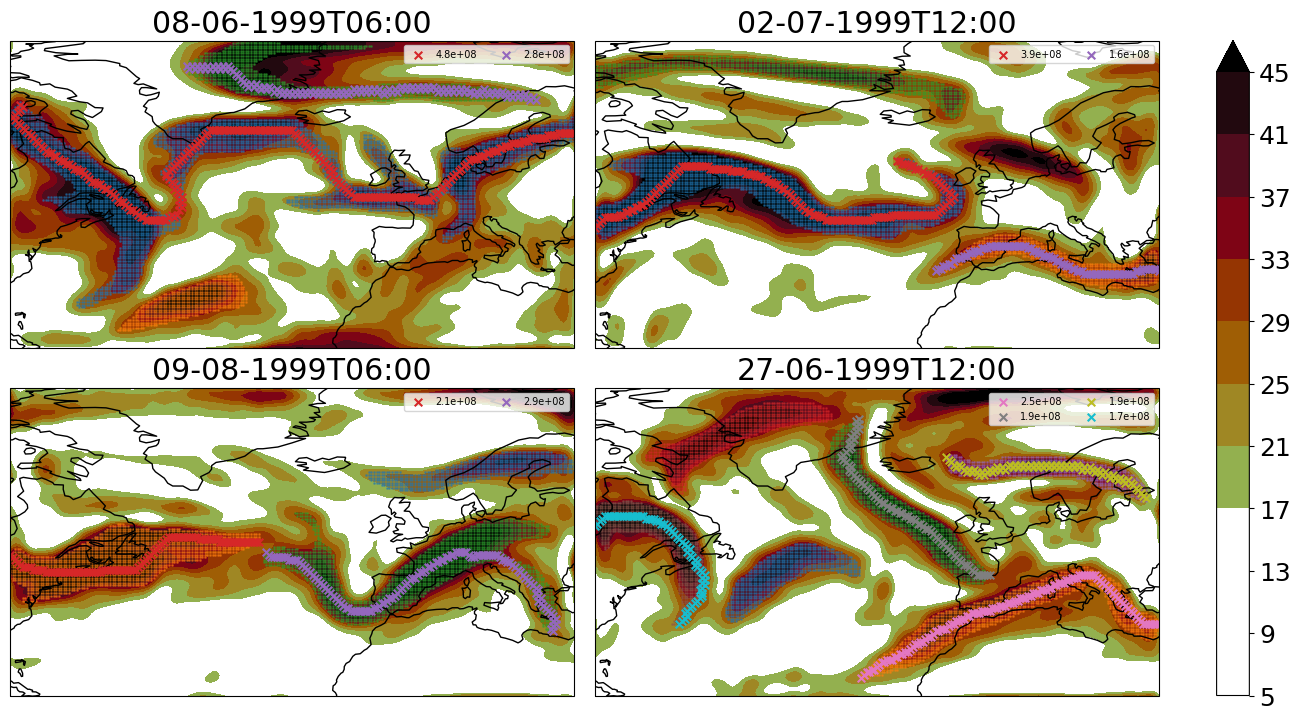

In [23]:
clu = Clusterplot(2, 2, get_region(ds))
its = np.random.randint(0, ds.time.shape[0], size=clu.nrow * clu.ncol)
norm = Normalize(.5, 4)
dss = []
for it in its:
    ds_ = ds.isel(time=it).copy()
    ds_ = preprocess(ds_, sigmas=range(3, 6))
    dss.append(ds_)
_ = clu.add_contourf([ds_["s_smooth"] for ds_ in dss], q=0.95, cmap=DEFAULT_COLORMAP, transparify=3, nlevels=11)
# _ = clu.add_contour([ds_["s_smo"] for ds_ in dss], nlevels=5)
for ds_, ax in tqdm(zip(dss, clu.axes.ravel()), total=len(dss)):
    groups, dist_mats = cluster_wind_speed(ds_, criterion_threshold=7.5, distance_function=pairwise_distances, min_size=500, distance_threshold=1.5)
    for group, dist_mat in zip(groups, dist_mats):
        ax.scatter(*group[["lon", "lat"]].to_numpy().T, s=1, alpha=0.5)
    jets = []
    for group, dist_mat in zip(groups, dist_mats):
        masked_weights = compute_weights(group, dist_mat)
        graph = create_graph(masked_weights, dist_mat)
        jet = find_jets_in_group_v2(graph, group, dist_mat, 1.3e8)
        if jet is not None:
            jets.append(jet)
    for jet in jets:
        ax.scatter(*jet[["lon", "lat"]].to_numpy().T, marker="x", s=30, label=f"{jet_integral_haversine(jet[['lon', 'lat', 's']].to_numpy()):.1e}", zorder=2)
    ax.set_title(ds_.time.dt.strftime("%d-%m-%YT%H:00").item())
    ax.legend(ncol=2, fontsize=7)
# plt.colorbar(im, ax=clu.axes)

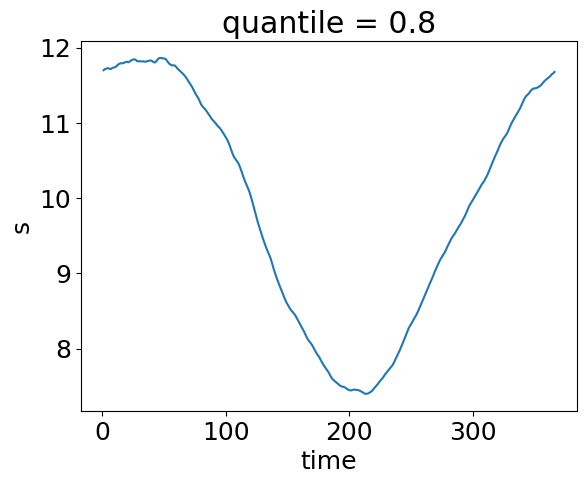

In [14]:
(qss[20, :] / 4).plot(hue="quantile") 

In [3]:
jet_finder = JetFinder(
    preprocess=preprocess,
    cluster = cluster_wind_speed,
    refine_jets=jets_from_mask,
)

In [15]:
jets = jet_finder.call(ds, thresholds=qss[20, :] / 4, processes=12)

100%|██████████| 1460/1460 [04:12<00:00,  5.78it/s]


# Anim demo

MovieWriter ffmpeg unavailable; using Pillow instead.


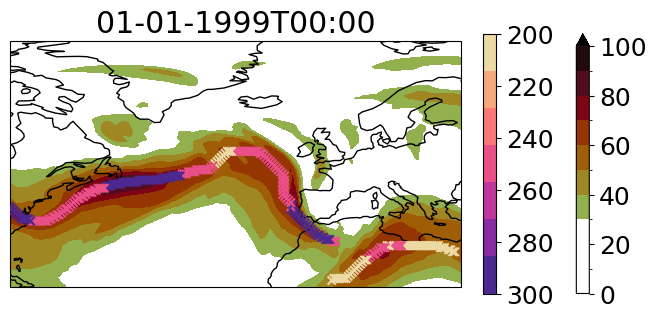

In [16]:
from matplotlib.collections import LineCollection, PathCollection
from matplotlib.animation import FuncAnimation

clu = Clusterplot(1, 1, get_region(ds))
fig = clu.fig
ax = clu.axes[0]
times = ds.time
lon, lat = ds.lon.values, ds.lat.values
ds_flat = flatten_by(ds, "s")
kwargs_contourf, _, _, _ = clu.setup_contourf(
    [ds_flat["s"].isel(time=0)], transparify=3, q=0.9, nlevels=11,
)
cs = ax.contourf(
    lon, lat, ds_flat["s"].isel(time=0).values, **kwargs_contourf
)
cmap_scatter = colormaps.agsunset_r
norm_scatter = Normalize(ds.lev.min(), ds.lev.max())
offsets = []
colors = []
for jet in jets[0]:
    offsets.append(jet[["lon", "lat"]])
    colors.append(jet["lev"])
pc = ax.scatter(*offsets[0].to_numpy().T, c=colors[0].tolist(), marker='x', norm=norm_scatter, cmap=cmap_scatter, zorder=100)
pc.set_offsets(np.concatenate(offsets))
pc.set_array(np.concatenate(colors))
cbar = fig.colorbar(cs, shrink=0.75)
cbar2 = fig.colorbar(pc, shrink=0.75)
cbar2.ax.invert_yaxis()

def animate(i):
    global pc
    global cs
    for c in cs.collections:
        c.remove()
    offsets = []
    colors = []
    for jet in jets[i]:
        offsets.append(jet[["lon", "lat"]])
        colors.append(jet["lev"])
    try:
        offsets = np.concatenate(offsets)
        colors = np.concatenate(colors)
    except ValueError:
        offsets = np.asarray([[0, 0]])
        colors = [0.5]
    pc.set_offsets(offsets)
    pc.set_array(colors)
    cs = ax.contourf(
        lon, lat, ds_flat["s"].isel(time=i).values, **kwargs_contourf
    )
    ax.set_title(times[i].dt.strftime("%d-%m-%YT%H:00").item())
    return pc, cs


ani = FuncAnimation(fig, animate, frames=np.arange(0, len(times), 8))
ani.save("Figures/jet_anim.gif", dpi=150, fps=1)

# High wind climatology

In [6]:
s = open_da("ERA5", "plev", "s", "6H", np.arange(1940, 2025, 5), None, -80, 30, 20, 75)
sflat = s.max(dim="lev")
q = sflat.quantile(0.75, dim=["lon", "lat"])
with ProgressBar():
    q = q.compute(**COMPUTE_KWARGS)

/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/data.py:332: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif period == "all":


[########################################] | 100% Completed | 339.12 s


In [7]:
with ProgressBar():
    sflat = sflat.compute(**COMPUTE_KWARGS)

[########################################] | 100% Completed | 400.76 s


In [8]:
q = sflat.quantile(np.arange(60, 100) / 100, dim=["lon", "lat"])

In [9]:
q_clim = compute_clim(q, "dayofyear")
smooth(q_clim, {"dayofyear": ("win", 60)}).to_netcdf("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/s/6H/results/qs_clim.nc")

In [10]:
q_clim = xr.open_dataarray("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/s/6H/results/qs_clim.nc")

In [12]:
q_clim.sel(quantile=0.75)

<xarray.DataArray 's' (dayofyear: 366)>
[366 values with dtype=float64]
Coordinates:
    quantile   float64 0.75
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366